# DESI Bulk Spectrum Retrieval
use desi-dr1 venv
Fixed version that uses wsdb to get correct redshifts and targetids with proper selection criteria.

In [6]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlutilpy as sqlutil  # FIXED: was just 'sqlutil'
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.ndimage import median_filter
from dl import authClient
from sparcl.client import SparclClient

In [11]:
base_path   = os.path.expanduser("~/Work/Code/lrd_search/")

In [7]:
# Define target coordinates (RA, Dec in degrees)
coord_flag = 0  # 0: use LRD candidates from lrd_can_radec.fits, 1: use hardcoded list below

if coord_flag == 0:
    # Load LRD candidates from FITS file
    try:
        from astropy.table import Table
        
        # Load the LRD candidate coordinates from FITS file
        lrd_fits_path = os.path.expanduser("~/data/lrd_search/lrd_can_radec.fits")
        print(f"Loading LRD candidates from: {lrd_fits_path}")
        
        radec_tbl = Table.read(lrd_fits_path)
        
        # Extract coordinates - assuming columns are 'ra' and 'dec' or similar
        # Adjust column names if different in your FITS file
        if 'ra' in radec_tbl.colnames and 'dec' in radec_tbl.colnames:
            ra_col, dec_col = 'ra', 'dec'
        elif 'decals_ra' in radec_tbl.colnames and 'decals_dec' in radec_tbl.colnames:
            ra_col, dec_col = 'decals_ra', 'decals_dec'
        else:
            # Try to find RA/Dec columns automatically
            ra_candidates = [col for col in radec_tbl.colnames if 'ra' in col.lower()]
            dec_candidates = [col for col in radec_tbl.colnames if 'dec' in col.lower()]
            
            if ra_candidates and dec_candidates:
                ra_col, dec_col = ra_candidates[0], dec_candidates[0]
                print(f"Auto-detected coordinate columns: {ra_col}, {dec_col}")
            else:
                raise ValueError("Could not find RA/Dec columns in FITS file")
        
        # Convert to coordinate list
        coordinates = list(zip(radec_tbl[ra_col], radec_tbl[dec_col]))
        
        print(f"Successfully loaded {len(coordinates)} LRD candidate coordinates")
        print(f"Using columns: {ra_col}, {dec_col}")
        
    except Exception as e:
        print(f"Error loading LRD candidates from FITS file: {e}")
        print("Falling back to hardcoded coordinates")
        coord_flag = 1
        
if coord_flag == 1:
    # Hardcoded coordinate list
    coordinates = [
        (358.916381, 26.489498),
        (354.480249, 2.013534),
        (10.921895, 0.881483),
        (210.875275, 30.749238),
        (343.842077, -9.646738),
        (23.300231, 31.742213),
        (215.210513, 31.092337),
        (236.325204, 46.643903),
        (253.144957, 33.840117),
        (165.126986, 45.059593),
        (236.911819, 31.719851),
        (158.573161, 29.148749),
        (66.399673, -4.495508),
        (219.589160, 9.773104),
        (340.102654, -4.759086),
        (138.169430, 22.449861),
        (139.005331, 0.525526),
        (351.856485, -5.221229),
        (173.764648, -2.898380),
        (130.045524, 37.499944),
        (238.155925, 61.612295),
        (202.880899, 40.349495),
        (215.581458, 13.371943),
        (154.924976, 30.076994),
        (236.837688, 49.619049),
        (353.404523, -3.251746),
        (227.966259, 21.777328),
        (212.959222, 23.486256),
        (197.557067, 65.920409),
        (222.493604, 44.778993),
        (156.376216, 14.035388),
        (142.579650, 26.240294),
        (317.432789, -1.693356),
        (223.333657, 28.347367),
        (314.773826, -5.213010),
        (351.038837, -3.092174),
        (168.108154, 51.313657),
        (123.549326, 55.670092),
        (222.816822, 35.082054),
        (5.152149, 28.881402),
        (32.861621, -18.995486),
        (261.289022, 32.442865),
        (162.827221, 8.306628),
        (337.041501, 13.347446),
        (134.822822, 9.908712),
        (44.274044, -2.032631),
        (136.195564, 58.350236),
        (1.605899, -4.167709),
        (30.545919, -4.451049),
        (338.987786, 15.550345),
        (200.015277, 20.450202),
        (231.408754, 41.533478),
        (158.599131, -2.476859),
        (170.352384, 57.091484),
        (195.918671, 13.447945),
        (32.563114, -3.735333),
        (204.736544, 20.410206),
        (208.706344, 2.124146),
        (268.187789, 63.377355),
        (164.482324, 58.432848),
        (166.908722, 29.463254),
        (145.788729, 33.631390),
        (149.813751, 3.676001),
        (194.052494, 27.974777),
        (161.212050, 60.872274),
        (229.980830, 19.439928),
        (162.058376, 54.635632),
        (143.786150, 44.948000),
        (176.948651, 18.388698),
        (191.804426, 22.609301),
        (150.376999, 34.708752),
        (249.560156, 24.401704),
        (316.359223, -3.042861),
        (245.954659, 28.065296),
        (242.442498, 6.013036),
        (337.770195, 21.766071),
        (180.039439, -1.188417),
        (180.692025, -0.872761),
        (20.793841, -10.518560),
        (253.917826, 21.997469),
        (180.228091, 51.175951),
        (8.333807, 30.001778),
        (28.391050, -7.938864),
        (212.100201, 8.185628),
        (183.645711, 33.162615),
        (207.025516, 37.044652),
        (213.475414, 16.753262),
        (178.083002, 58.699055),
        (190.936333, 20.366452),
        (245.007099, 42.610997),
        (196.416820, 39.653257),
        (223.940808, 10.652031),
        (11.727513, 25.209096),
        (202.348559, 37.615507),
        (158.427333, 47.514811),
        (164.710438, 65.035288),
        (166.776330, 65.088561),
        (196.219836, 18.185969),
        (172.897194, 35.025975),
        (145.589148, 15.079138),
        (144.815770, 21.200214),
        (195.525519, 40.044605),
        (245.757160, 39.257959),
        (165.078380, 8.082036),
        (251.147127, 50.281261),
        (202.752545, 44.283004),
        (257.607620, 29.538230),
        (178.309853, 3.449596),
        (159.597856, 59.707331),
        (205.368035, -0.522329),
        (135.219266, 5.996941),
        (205.999319, 40.818289),
        (226.085088, 41.819358),
    ]
    print(f"Using {len(coordinates)} hardcoded coordinates")

print(f"Target coordinates: {len(coordinates)} positions")
if coord_flag == 0:
    print("Source: LRD candidates from lrd_can_radec.fits")
else:
    print("Source: Hardcoded coordinate list")
    
for i, (ra, dec) in enumerate(coordinates[:10]):  # Show first 10 only
    print(f"  {i+1}. RA={ra:.6f}°, Dec={dec:.6f}°")
if len(coordinates) > 10:
    print(f"  ... and {len(coordinates)-10} more coordinates")

Loading LRD candidates from: /Users/vasilybelokurov/data/lrd_search/lrd_can_radec.fits
Successfully loaded 69 LRD candidate coordinates
Using columns: ra, dec
Target coordinates: 69 positions
Source: LRD candidates from lrd_can_radec.fits
  1. RA=354.480249°, Dec=2.013534°
  2. RA=10.921895°, Dec=0.881483°
  3. RA=210.875275°, Dec=30.749238°
  4. RA=343.842077°, Dec=-9.646738°
  5. RA=23.300231°, Dec=31.742213°
  6. RA=215.210513°, Dec=31.092337°
  7. RA=236.911819°, Dec=31.719851°
  8. RA=66.399673°, Dec=-4.495508°
  9. RA=219.589160°, Dec=9.773104°
  10. RA=173.764648°, Dec=-2.898380°
  ... and 59 more coordinates


In [8]:
# Search DESI DR1 using wsdb with proper selection criteria
def search_desi_wsdb(coord_list, radius_arcsec=1.0):
    """Search DESI DR1 using wsdb with best spectrum selection"""
    
    results = []
    radius_deg = radius_arcsec / 3600.0
    
    print(f"🔍 Searching DESI DR1 via wsdb within {radius_arcsec}\" of {len(coord_list)} coordinates...")
    
    for i, (ra, dec) in enumerate(coord_list):
        print(f"  {i+1}/{len(coord_list)}: RA={ra:.6f}, Dec={dec:.6f}")
        
        # FIXED SQL query - removed problematic DISTINCT ON syntax
        query = f"""
        SELECT 
            p.targetid,
            p.ra as spec_ra,
            p.dec as spec_dec,
            z.z as redshift,
            z.zerr as redshift_error,
            z.spectype,
            z.zwarn,
            z.tsnr2_gpbdark,
            z.tsnr2_qso,
            z.deltachi2,
            z.survey,
            z.program,
            q3c_dist(p.ra, p.dec, {ra}, {dec}) * 3600 as sep_arcsec
        FROM desi_dr1.photometry p
        LEFT JOIN desi_dr1.zpix z ON z.targetid = p.targetid
        WHERE q3c_radial_query(p.ra, p.dec, {ra}, {dec}, {radius_deg})
        ORDER BY 
            CASE WHEN z.z IS NOT NULL THEN 1 ELSE 2 END,  -- redshifts first
            z.tsnr2_gpbdark DESC NULLS LAST,               -- highest S/N
            q3c_dist(p.ra, p.dec, {ra}, {dec})             -- closest
        LIMIT 1
        """
        
        try:
            result = sqlutil.get(query, asDict=True)
            
            # FIXED: Handle sqlutil return format correctly
            if result and len(result['targetid']) > 0:
                match = {
                    'targetid': result['targetid'][0],
                    'spec_ra': result['spec_ra'][0],
                    'spec_dec': result['spec_dec'][0],
                    'redshift': result['redshift'][0],
                    'redshift_error': result['redshift_error'][0],
                    'spectype': result['spectype'][0],
                    'zwarn': result['zwarn'][0],
                    'tsnr2_gpbdark': result['tsnr2_gpbdark'][0],
                    'tsnr2_qso': result['tsnr2_qso'][0],
                    'deltachi2': result['deltachi2'][0],
                    'survey': result['survey'][0],
                    'program': result['program'][0],
                    'sep_arcsec': result['sep_arcsec'][0],
                    'input_ra': ra,
                    'input_dec': dec,
                    'input_index': i
                }
                results.append(match)
                
                z_str = f"{match['redshift']:.4f}" if match['redshift'] is not None else "N/A"
                spectype = match['spectype'] if match['spectype'] else "N/A"
                snr = f"{match['tsnr2_gpbdark']:.0f}" if match['tsnr2_gpbdark'] else "N/A"
                
                print(f"    ✓ TARGETID={match['targetid']}, sep={match['sep_arcsec']:.3f}\", "
                      f"type={spectype}, z={z_str}, S/N={snr}")
            else:
                print(f"    ✗ No DESI target found")
                
        except Exception as e:
            print(f"    ✗ Query error: {e}")
    
    return pd.DataFrame(results)

# Execute wsdb search
search_results = search_desi_wsdb(coordinates)
print(f"\n✅ Found {len(search_results)} DESI matches")

if len(search_results) > 0:
    print(f"Coverage: {len(search_results)}/{len(coordinates)} coordinates have DESI data")
    search_results.to_csv('desi_bulk_search_results.csv', index=False)
    print("💾 Results saved to desi_bulk_search_results.csv")
    
    # Display results
    print("\n📋 SEARCH RESULTS:")
    for _, row in search_results.iterrows():
        z_str = f"{row['redshift']:.4f}" if row['redshift'] is not None else "N/A"
        snr_str = f"{row['tsnr2_gpbdark']:.0f}" if row['tsnr2_gpbdark'] is not None else "N/A"
        print(f"  RA={row['input_ra']:.6f}, Dec={row['input_dec']:.6f} → "
              f"TARGETID={row['targetid']}, z={z_str}, S/N={snr_str}, type={row['spectype']}")

🔍 Searching DESI DR1 via wsdb within 1.0" of 69 coordinates...
  1/69: RA=354.480249, Dec=2.013534
    ✗ No DESI target found
  2/69: RA=10.921895, Dec=0.881483
    ✓ TARGETID=2785373444898816, sep=0.000", type=None, z=nan, S/N=nan
  3/69: RA=210.875275, Dec=30.749238
    ✗ No DESI target found
  4/69: RA=343.842077, Dec=-9.646738
    ✗ No DESI target found
  5/69: RA=23.300231, Dec=31.742213
    ✗ No DESI target found
  6/69: RA=215.210513, Dec=31.092337
    ✓ TARGETID=39628502089076932, sep=0.000", type=QSO, z=0.9940, S/N=11810
  7/69: RA=236.911819, Dec=31.719851
    ✓ TARGETID=39628517901599269, sep=0.000", type=QSO, z=0.3785, S/N=8683
  8/69: RA=66.399673, Dec=-4.495508
    ✓ TARGETID=2785241555009541, sep=0.000", type=None, z=nan, S/N=nan
  9/69: RA=219.589160, Dec=9.773104
    ✓ TARGETID=39628022998893485, sep=0.000", type=None, z=nan, S/N=nan
  10/69: RA=173.764648, Dec=-2.898380
    ✓ TARGETID=39627715166339427, sep=0.000", type=QSO, z=1.3338, S/N=12160
  11/69: RA=238.155925,

In [14]:
# Now retrieve spectra using SPARCL with the correct targetids
if len(search_results) > 0:
    
    # Authenticate with DataLab
    token_path = os.path.expanduser("~/.datalab/id_token.vasily")
    with open(token_path, 'r') as f:
        token = f.read().strip()
        os.environ['DATALAB_TOKEN'] = token
    
    print("Authenticated as:", authClient.whoAmI())
    
    # Initialize SPARCL client
    client = SparclClient()
    
    # Retrieve spectra using targetids
    targetids = search_results['targetid'].tolist()
    print(f"\n📡 Retrieving spectra for {len(targetids)} targetids...")
    
    spectra_data = []
    
    for _, row in search_results.iterrows():
        targetid = row['targetid']
        print(f"  Retrieving TARGETID={targetid}")
        
        try:
            # Use specid = targetid for DESI
            retr = client.retrieve_by_specid(
                specid_list=[targetid],
                include=['wavelength', 'flux']
            )
            
            if retr.records:
                spec = retr.records[0]
                spectrum_data = {
                    'targetid': targetid,
                    'input_ra': row['input_ra'],
                    'input_dec': row['input_dec'],
                    'spec_ra': row['spec_ra'],
                    'spec_dec': row['spec_dec'],
                    'separation': row['sep_arcsec'],
                    'survey': row['survey'],
                    'program': row['program'],
                    'spectype': row['spectype'],
                    'redshift': row['redshift'],
                    'redshift_error': row['redshift_error'],
                    'zwarn': row['zwarn'],
                    'tsnr2_gpbdark': row['tsnr2_gpbdark'],
                    'wavelength': spec.wavelength,
                    'flux': spec.flux
                }
                spectra_data.append(spectrum_data)
                print(f"    ✓ Retrieved: λ={spec.wavelength.min():.0f}-{spec.wavelength.max():.0f}Å")
            else:
                print(f"    ✗ No spectrum data for TARGETID={targetid}")
        
        except Exception as e:
            print(f"    ✗ Error: {e}")
    
    print(f"\n✅ Successfully retrieved {len(spectra_data)} spectra")
    
    # Save spectrum data
    if spectra_data:
        import pickle
        with open(os.path.join(base_path, 'aux_data', 'desi_bulk_spectra.pkl'), 'wb') as f:
            pickle.dump(spectra_data, f)
        print("💾 Spectrum data saved to desi_bulk_spectra.pkl")
else:
    spectra_data = []
    print("No spectra to retrieve")

Authenticated as: vasily

📡 Retrieving spectra for 35 targetids...
  Retrieving TARGETID=2785373444898816
    ✗ No spectrum data for TARGETID=2785373444898816
  Retrieving TARGETID=39628502089076932
    ✓ Retrieved: λ=3600-9824Å
  Retrieving TARGETID=39628517901599269
    ✓ Retrieved: λ=3600-9824Å
  Retrieving TARGETID=2785241555009541
    ✗ No spectrum data for TARGETID=2785241555009541
  Retrieving TARGETID=39628022998893485
    ✗ No spectrum data for TARGETID=39628022998893485
  Retrieving TARGETID=39627715166339427
    ✓ Retrieved: λ=3600-9824Å
  Retrieving TARGETID=39628301987220002
    ✓ Retrieved: λ=3600-9824Å
  Retrieving TARGETID=39627663266025584
    ✗ No spectrum data for TARGETID=39627663266025584
  Retrieving TARGETID=39627718140101333
    ✓ Retrieved: λ=3600-9824Å
  Retrieving TARGETID=2785672226144259
    ✗ No spectrum data for TARGETID=2785672226144259
  Retrieving TARGETID=39633364872856429
    ✓ Retrieved: λ=3600-9824Å
  Retrieving TARGETID=2785246495899648
    ✗ No s


💾 Saving individual DESI spectrum plots...
   💾 Saved: desi_ra215.2105_dec+31.0923.png
   💾 Saved: desi_ra236.9118_dec+31.7199.png
   💾 Saved: desi_ra173.7646_dec-02.8984.png
   💾 Saved: desi_ra227.9663_dec+21.7773.png
   💾 Saved: desi_ra351.0388_dec-03.0922.png
   💾 Saved: desi_ra136.1956_dec+58.3502.png
   💾 Saved: desi_ra030.5459_dec-04.4510.png
   💾 Saved: desi_ra338.9878_dec+15.5503.png
   💾 Saved: desi_ra208.7063_dec+02.1241.png
   💾 Saved: desi_ra149.8138_dec+03.6760.png
   💾 Saved: desi_ra194.0525_dec+27.9748.png
   💾 Saved: desi_ra161.2120_dec+60.8723.png
   💾 Saved: desi_ra316.3592_dec-03.0429.png
   💾 Saved: desi_ra245.9547_dec+28.0653.png
   💾 Saved: desi_ra337.7702_dec+21.7661.png
   💾 Saved: desi_ra183.6457_dec+33.1626.png
   💾 Saved: desi_ra245.7572_dec+39.2580.png
   💾 Saved: desi_ra251.1471_dec+50.2813.png
   💾 Saved: desi_ra205.9993_dec+40.8183.png
   💾 Saved: desi_ra226.0851_dec+41.8194.png


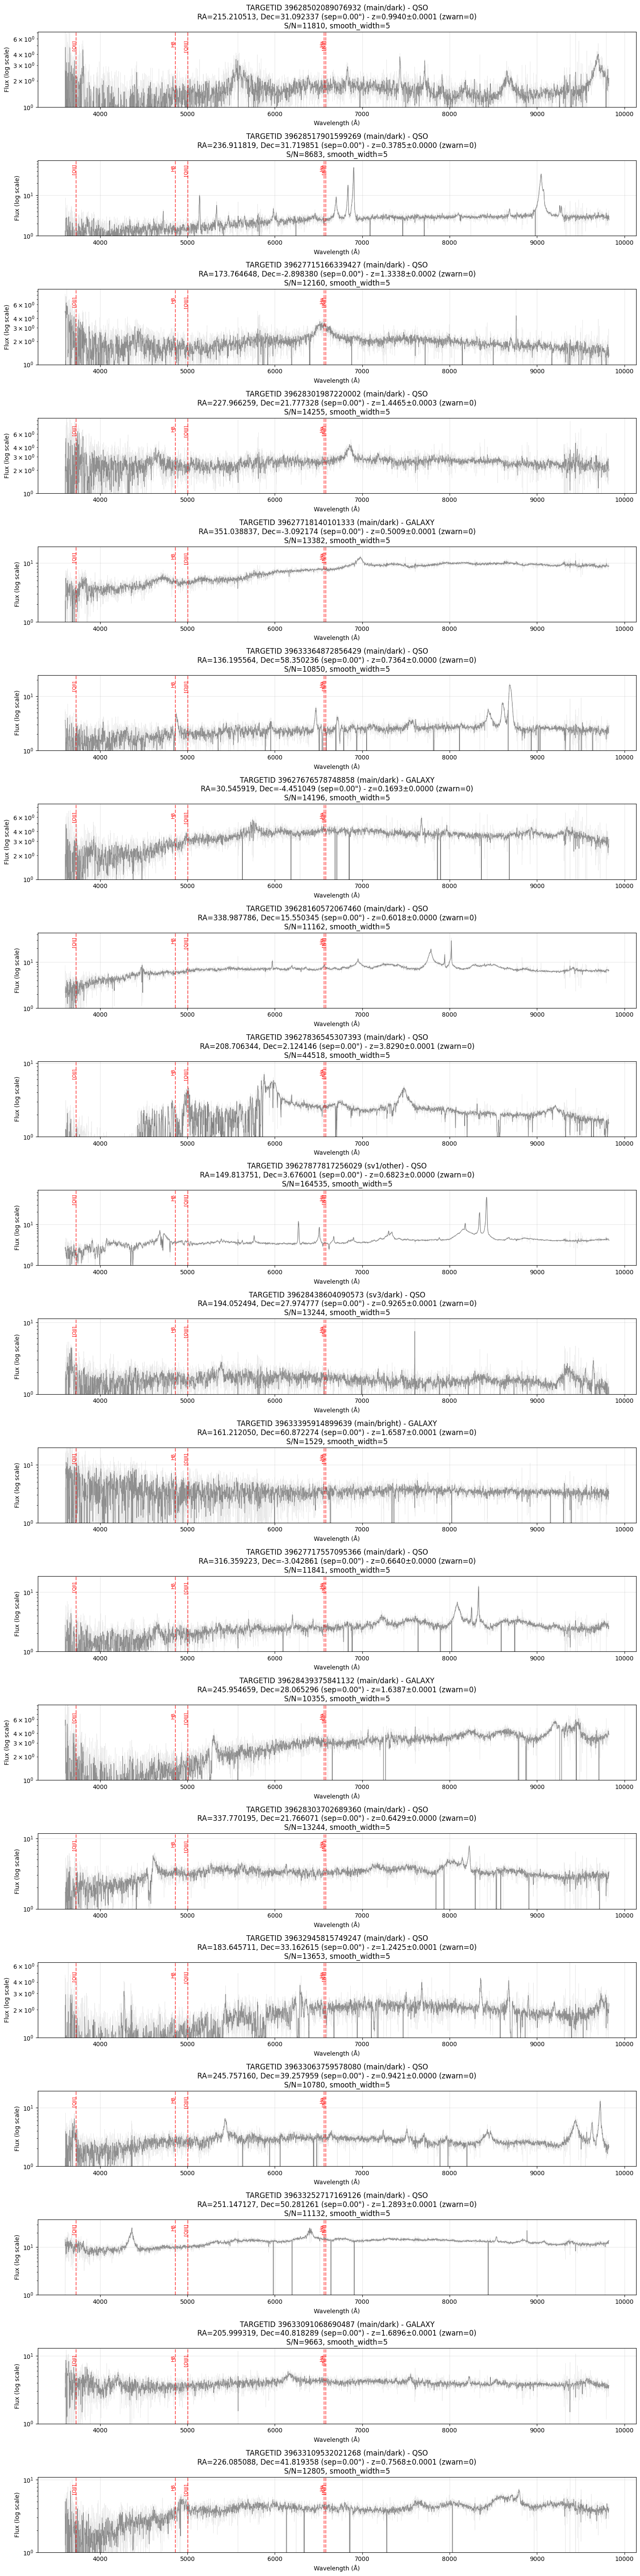


   Data source: wsdb
   Selection: Best S/N spectrum per position
   Redshifts: From DESI DR1 zpix table
   Individual plots saved to: ~/data/lrd_search/desi_spectra/


In [13]:
# Plot spectra with correct redshifts

def plot_spectra_fixed(spectra_data, smooth_width=5):
    """Plot spectra with correct redshifts from wsdb and save individual plots"""
    
    if not spectra_data:
        print("No spectra to plot")
        return
    
    n_spectra = len(spectra_data)
    fig, axes = plt.subplots(n_spectra, 1, figsize=(15, 3*n_spectra))
    
    if n_spectra == 1:
        axes = [axes]
    
    print(f"\n💾 Saving individual DESI spectrum plots...")
    
    for i, spec in enumerate(spectra_data):
        wave = spec['wavelength']
        flux = spec['flux']
        ra = spec['input_ra']
        dec = spec['input_dec']
        
        # Apply median smoothing
        flux_smooth = median_filter(flux, size=smooth_width)
        flux_plot = np.where(flux_smooth > 0, flux_smooth, 1e-10)
        
        # Plot spectrum on main figure
        axes[i].plot(wave, flux_plot, 'k-', linewidth=0.8, alpha=0.7, label='Smoothed')
        axes[i].plot(wave, np.where(flux > 0, flux, 1e-10), '-', color='lightgray', 
                    linewidth=0.5, alpha=0.5, label='Original')
        
        axes[i].set_yscale('log')
        axes[i].set_ylim(bottom=1, top=1.5*np.max(flux_plot))
        axes[i].set_xlabel('Wavelength (Å)')
        axes[i].set_ylabel('Flux (log scale)')
        
        # Enhanced title with CORRECT redshift
        z_str = f"z={spec['redshift']:.4f}" if spec['redshift'] is not None else "z=N/A"
        zerr_str = f"±{spec['redshift_error']:.4f}" if spec['redshift_error'] is not None else ""
        zwarn_str = f"(zwarn={spec['zwarn']})" if spec['zwarn'] is not None else ""
        spectype_str = spec['spectype'] if spec['spectype'] else "Unknown"
        snr_str = f"S/N={spec['tsnr2_gpbdark']:.0f}" if spec['tsnr2_gpbdark'] is not None else "S/N=N/A"
        
        title_text = (f"TARGETID {spec['targetid']} ({spec['survey']}/{spec['program']}) - {spectype_str}\n"
                     f"RA={spec['input_ra']:.6f}, Dec={spec['input_dec']:.6f} "
                     f"(sep={spec['separation']:.2f}\") - {z_str}{zerr_str} {zwarn_str}\n"
                     f"{snr_str}, smooth_width={smooth_width}")
        
        axes[i].set_title(title_text)
        axes[i].grid(True, alpha=0.3)
        
        # Add emission lines
        line_waves = [3727, 4861, 5007, 6563, 6584]
        line_names = ['[OII]', 'Hβ', '[OIII]', 'Hα', '[NII]']
        
        for line_wave, line_name in zip(line_waves, line_names):
            if wave.min() <= line_wave <= wave.max():
                axes[i].axvline(line_wave, color='red', linestyle='--', alpha=0.6)
                axes[i].text(line_wave, axes[i].get_ylim()[1]*0.8, line_name, 
                           rotation=90, ha='right', va='top', fontsize=8, color='red')
        
        # Create individual plot for saving
        fig_single, ax_single = plt.subplots(1, 1, figsize=(12, 6))
        
        # Plot on individual figure
        ax_single.plot(wave, flux_plot, 'k-', linewidth=0.8, alpha=0.7, label='Smoothed')
        ax_single.plot(wave, np.where(flux > 0, flux, 1e-10), '-', color='lightgray', 
                      linewidth=0.5, alpha=0.5, label='Original')
        
        ax_single.set_yscale('log')
        ax_single.set_ylim(bottom=1, top=1.5*np.max(flux_plot))
        ax_single.set_xlabel('Wavelength (Å)')
        ax_single.set_ylabel('Flux (log scale)')
        ax_single.set_title(title_text)
        ax_single.grid(True, alpha=0.3)
        ax_single.legend()
        
        # Add emission lines to individual plot
        for line_wave, line_name in zip(line_waves, line_names):
            if wave.min() <= line_wave <= wave.max():
                ax_single.axvline(line_wave, color='red', linestyle='--', alpha=0.6)
                ax_single.text(line_wave, ax_single.get_ylim()[1]*0.8, line_name, 
                              rotation=90, ha='right', va='top', fontsize=8, color='red')
        
        # Generate filename with RA and Dec (same logic as vizier_sed.ipynb)
        filename = f"desi_ra{ra:08.4f}_dec{dec:+08.4f}.png"
        filepath = f"~/data/lrd_search/desi_spectra/{filename}"
        
        # Save the individual plot
        fig_single.savefig(os.path.join(base_path, "desi_spectra", filename), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig_single)  # Close to free memory
        
        print(f"   💾 Saved: {filename}")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n   Data source: wsdb")
    print(f"   Selection: Best S/N spectrum per position")
    print(f"   Redshifts: From DESI DR1 zpix table")
    print(f"   Individual plots saved to: ~/data/lrd_search/desi_spectra/")

# Create plots with correct data
if spectra_data:
    plot_spectra_fixed(spectra_data, smooth_width=5)
else:
    print("No spectra data to plot")